In [12]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # silence RDKit warnings
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw

import random
from collections import Counter
from rdkit import Chem
# from rdkit.Chem import rdchem, rdMolOps, rdMolDescriptors as Descr, AllChem, rdmolfiles, rdmolops
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
# --- add this at the very top ---
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import random
from collections import Counter
from rdkit import Chem
from rdkit.Chem import rdchem, rdMolDescriptors as Descr, AllChem, rdmolfiles, rdmolops
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
# --------------------------
# Config (tweak as you like)
# --------------------------
RNG_SEED = 13
N_CANDIDATES = 8000          # how many random molecules to attempt
HEAVY_ATOM_MIN = 2
HEAVY_ATOM_MAX = 30           # "small molecules"
MAX_COMPONENTS = 1            # keep only single-component molecules
TARGET_SIZE = 60             # final size of benchmark set
SYMMETRY_HEAVY_FRACTION = 0.5 # fraction taken by symmetry-enriched selection
ECFP_RADIUS = 2
ECFP_NBITS = 2048

# Allowed elements and typical valence targets
ALLOWED = {
    "C": [4],
    "N": [3,4],   # allow cationic amines etc.
    "O": [2,1],   # allow [O-]
    "F": [1],
    "S": [2,4,6]  # allow common hypervalent S forms
}
ALLOWED_SYMBOLS = list(ALLOWED.keys())

random.seed(RNG_SEED)

# --------------------------
# Helpers
# --------------------------

def _formal_charge(mol: Chem.Mol) -> int:
    return Chem.GetFormalCharge(mol)

def _ok_elements(mol: Chem.Mol) -> bool:
    for a in mol.GetAtoms():
        if a.GetSymbol() not in ALLOWED:
            return False
    return True

def _heavy_count(mol: Chem.Mol) -> int:
    return sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() > 1)

def _is_single_component(mol: Chem.Mol) -> bool:
    frags = Chem.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
    return len(frags) == 1

def _try_sanitize(mol: Chem.RWMol):
    try:
        nm = mol.GetMol()
        Chem.SanitizeMol(nm)
        return nm
    except Exception:
        return None

def _random_atom_symbol():
    # Bias towards C,N,O a bit, but include F,S
    choices = ["C"]*6 + ["N"]*3 + ["O"]*3 + ["F"]*2 + ["S"]*2
    return random.choice(choices)

def _random_bond_type():
    # Favor single bonds; occasional double/triple to create diversity
    return random.choices(
        population=[rdchem.BondType.SINGLE, rdchem.BondType.DOUBLE, rdchem.BondType.TRIPLE],
        weights=[0.80, 0.18, 0.02],
        k=1
    )[0]

def _random_charge_for_atom(sym):
    # Introduce an occasional formal charge consistent with common chemistry
    if random.random() < 0.03:
        if sym == "N":
            return random.choice([0, +1])
        if sym == "O":
            return random.choice([0, -1])
        if sym == "S":
            return random.choice([0, +1])  # rare; RDKit sanitization will reject nonsense
    return 0

    
def grow_random_molecule():
    """Valence-aware growth: build a connected graph that won't exceed per-atom target valence."""
    n_heavy = random.randint(HEAVY_ATOM_MIN, HEAVY_ATOM_MAX)
    rw = Chem.RWMol()
    atoms = []
    rem_val = {}    # remaining valence budget (integers)
    allowed = {}    # allowed bond orders per atom index (set)

    # start atom
    sym0 = _random_atom_symbol()
    ch0 = _allowed_charge(sym0)
    tgt0, allowed0 = _choose_valence(sym0, ch0)
    a0 = rdchem.Atom(sym0)
    a0.SetFormalCharge(ch0)
    i0 = rw.AddAtom(a0)
    atoms.append(i0)
    rem_val[i0] = tgt0
    allowed[i0] = set(allowed0)

    # grow a tree
    for _ in range(1, n_heavy):
        sym = _random_atom_symbol()
        ch = _allowed_charge(sym)
        tgt, allowset = _choose_valence(sym, ch)
        new_a = rdchem.Atom(sym)
        new_a.SetFormalCharge(ch)
        j = rw.AddAtom(new_a)

        # find a partner with remaining valence
        partners = [i for i in atoms if rem_val[i] > 0]
        if not partners:
            # no available valence -> fail early
            return None
        i = random.choice(partners)

        # pick a bond order compatible with both
        bo = _bond_order_choice(allowed[i], set(allowset))
        if bo is None or rem_val[i] < bo or tgt < bo:
            # try a few alternative partners before giving up
            ok = False
            random.shuffle(partners)
            for i_try in partners:
                bo = _bond_order_choice(allowed[i_try], set(allowset))
                if bo is not None and rem_val[i_try] >= bo and tgt >= bo:
                    i = i_try
                    ok = True
                    break
            if not ok:
                return None

        # add bond
        bt = {1: rdchem.BondType.SINGLE, 2: rdchem.BondType.DOUBLE, 3: rdchem.BondType.TRIPLE}[bo]
        try:
            rw.AddBond(i, j, bt)
        except Exception:
            return None

        # book-keeping
        atoms.append(j)
        rem_val.setdefault(j, tgt)
        allowed[j] = set(allowset)
        rem_val[i] -= bo
        rem_val[j] -= bo

    # occasionally create a ring if both endpoints still have spare valence
    if len(atoms) >= 4 and random.random() < 0.25:
        for _ in range(3):  # small number of tries
            i, j = random.sample(atoms, 2)
            if i == j or rw.GetBondBetweenAtoms(i, j) is not None:
                continue
            # avoid making multiple bonds to F or to atoms with remaining valence 0
            if rem_val.get(i, 0) <= 0 or rem_val.get(j, 0) <= 0:
                continue
            bo = _bond_order_choice(allowed[i], allowed[j])
            if bo is None or rem_val[i] < bo or rem_val[j] < bo:
                continue
            try:
                rw.AddBond(i, j, {1: rdchem.BondType.SINGLE, 2: rdchem.BondType.DOUBLE}.get(bo, rdchem.BondType.SINGLE))
                rem_val[i] -= bo
                rem_val[j] -= bo
                break
            except Exception:
                pass

    # convert to mol, sanitize, let RDKit add H to satisfy leftover valence
    try:
        m = rw.GetMol()
    except Exception:
        return None

    # Sanitize softly -> AddHs -> sanitize fully
    try:
        Chem.SanitizeMol(m)
    except Exception:
        # try a softer path: skip kekulization/aromaticity in first pass
        try:
            Chem.SanitizeMol(m, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)
        except Exception:
            return None

    try:
        mH = Chem.AddHs(m)   # fill remaining valence with hydrogens
        Chem.SanitizeMol(mH)
        m = Chem.RemoveHs(mH, updateExplicitCount=True)
    except Exception:
        return None

    # final quick checks
    if not _ok_elements(m) or not _is_single_component(m) or _heavy_count(m) < HEAVY_ATOM_MIN:
        return None

    return m
from rdkit import Chem
from rdkit.Chem import rdchem, rdmolops

# Pick one “target valence” per element/charge, then consume it as bonds are added.
VALENCE_OPTIONS = {
    # element : list of (target_valence, allowed_bond_orders_for_this_element)
    "C": [(4, {1,2,3})],
    "N": [(3, {1,2}), (4, {1,2})],          # 4 for cationic amines, etc.
    "O": [(2, {1,2}), (1, {1})],            # (1,{1}) lets us realize [O-] after Hs are added
    "F": [(1, {1})],
    "S": [(2, {1,2}), (4, {1,2}), (6, {1,2})]
}

def _choose_valence(sym, charge):
    # bias toward neutral common states; only slightly toward charged ones
    opts = VALENCE_OPTIONS[sym]
    if charge != 0:
        return random.choice(opts)
    # neutral: prefer first option
    return random.choices(opts, weights=[3]+[1]*(len(opts)-1), k=1)[0]

def _allowed_charge(sym):
    # light chance to set a charge consistent with common chemistry
    r = random.random()
    if sym == "N" and r < 0.06:
        return +1
    if sym == "O" and r < 0.06:
        return -1
    if sym == "S" and r < 0.02:
        return +1
    return 0

def _bond_order_choice(allowed_i, allowed_j, max_order=3):
    # choose the largest order both allow, but mostly singles
    orders = sorted(allowed_i & allowed_j & {1,2,3})
    if not orders:
        return None
    return random.choices(orders, weights=[0.85, 0.13, 0.02][:len(orders)], k=1)[0]

def grow_random_molecule():
    """Valence-aware growth: build a connected graph that won't exceed per-atom target valence."""
    n_heavy = random.randint(HEAVY_ATOM_MIN, HEAVY_ATOM_MAX)
    rw = Chem.RWMol()
    atoms = []
    rem_val = {}    # remaining valence budget (integers)
    allowed = {}    # allowed bond orders per atom index (set)

    # start atom
    sym0 = _random_atom_symbol()
    ch0 = _allowed_charge(sym0)
    tgt0, allowed0 = _choose_valence(sym0, ch0)
    a0 = rdchem.Atom(sym0)
    a0.SetFormalCharge(ch0)
    i0 = rw.AddAtom(a0)
    atoms.append(i0)
    rem_val[i0] = tgt0
    allowed[i0] = set(allowed0)

    # grow a tree
    for _ in range(1, n_heavy):
        sym = _random_atom_symbol()
        ch = _allowed_charge(sym)
        tgt, allowset = _choose_valence(sym, ch)
        new_a = rdchem.Atom(sym)
        new_a.SetFormalCharge(ch)
        j = rw.AddAtom(new_a)

        # find a partner with remaining valence
        partners = [i for i in atoms if rem_val[i] > 0]
        if not partners:
            # no available valence -> fail early
            return None
        i = random.choice(partners)

        # pick a bond order compatible with both
        bo = _bond_order_choice(allowed[i], set(allowset))
        if bo is None or rem_val[i] < bo or tgt < bo:
            # try a few alternative partners before giving up
            ok = False
            random.shuffle(partners)
            for i_try in partners:
                bo = _bond_order_choice(allowed[i_try], set(allowset))
                if bo is not None and rem_val[i_try] >= bo and tgt >= bo:
                    i = i_try
                    ok = True
                    break
            if not ok:
                return None

        # add bond
        bt = {1: rdchem.BondType.SINGLE, 2: rdchem.BondType.DOUBLE, 3: rdchem.BondType.TRIPLE}[bo]
        try:
            rw.AddBond(i, j, bt)
        except Exception:
            return None

        # book-keeping
        atoms.append(j)
        rem_val.setdefault(j, tgt)
        allowed[j] = set(allowset)
        rem_val[i] -= bo
        rem_val[j] -= bo

    # occasionally create a ring if both endpoints still have spare valence
    if len(atoms) >= 4 and random.random() < 0.25:
        for _ in range(3):  # small number of tries
            i, j = random.sample(atoms, 2)
            if i == j or rw.GetBondBetweenAtoms(i, j) is not None:
                continue
            # avoid making multiple bonds to F or to atoms with remaining valence 0
            if rem_val.get(i, 0) <= 0 or rem_val.get(j, 0) <= 0:
                continue
            bo = _bond_order_choice(allowed[i], allowed[j])
            if bo is None or rem_val[i] < bo or rem_val[j] < bo:
                continue
            try:
                rw.AddBond(i, j, {1: rdchem.BondType.SINGLE, 2: rdchem.BondType.DOUBLE}.get(bo, rdchem.BondType.SINGLE))
                rem_val[i] -= bo
                rem_val[j] -= bo
                break
            except Exception:
                pass

    # convert to mol, sanitize, let RDKit add H to satisfy leftover valence
    try:
        m = rw.GetMol()
    except Exception:
        return None

    # Sanitize softly -> AddHs -> sanitize fully
    try:
        Chem.SanitizeMol(m)
    except Exception:
        # try a softer path: skip kekulization/aromaticity in first pass
        try:
            Chem.SanitizeMol(m, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)
        except Exception:
            return None

    try:
        mH = Chem.AddHs(m)   # fill remaining valence with hydrogens
        Chem.SanitizeMol(mH)
        m = Chem.RemoveHs(mH, updateExplicitCount=True)
    except Exception:
        return None

    # final quick checks
    if not _ok_elements(m) or not _is_single_component(m) or _heavy_count(m) < HEAVY_ATOM_MIN:
        return None

    return m


def symmetry_score(mol: Chem.Mol):
    """Return a tuple of symmetry-related metrics:
       - n_auto: number of graph automorphisms
       - n_classes: number of distinct canonical ranks
       - class_mult: multiset of class sizes (bigger degenerate classes -> more symmetry)
       We combine these into a single numeric score for sorting, but also store details.
    """
    try:
        autos = rdMolOps.GetAutomorphisms(mol)
    except Exception:
        autos = []
    n_auto = max(1, len(autos))

    # RDKit canonical ranks as a proxy for symmetry classes
    try:
        ranks = list(rdmolops.CanonicalRankAtoms(mol))
    except Exception:
        ranks = list(range(mol.GetNumAtoms()))

    cnt = Counter(ranks)
    class_sizes = sorted(cnt.values(), reverse=True)
    n_classes = len(cnt)

    # Heuristic score: more automorphisms + large degenerate classes = higher
    # Use product of (n_auto) and sum of squared class sizes
    s2 = sum(c*c for c in class_sizes)
    score = n_auto * (1 + s2)
    return score, n_auto, n_classes, class_sizes

def mol_fingerprint(mol: Chem.Mol):
    return Descr.GetMorganFingerprintAsBitVect(mol, ECFP_RADIUS, nBits=ECFP_NBITS)

def pick_diverse(mols, n_pick):
    if not mols:
        return []
    fps = [mol_fingerprint(m) for m in mols]
    dmat = []
    # RDKit’s MaxMinPicker expects a distance function; we can pass a precomputed “on-demand” callable,
    # but here we’ll inline via a closure over the list.
    def dist(i, j):
        return 1.0 - float(Chem.DataStructs.TanimotoSimilarity(fps[i], fps[j]))
    picker = MaxMinPicker()
    # seed with the single most symmetric molecule to encourage symmetry variety too
    seeds = [max(range(len(mols)), key=lambda i: mols[i].GetProp("_sym_score") if mols[i].HasProp("_sym_score") else 0)]
    picks = list(picker.LazyPick(dist, len(mols), n_pick, firstPicks=seeds))
    return [mols[i] for i in picks]

# --------------------------
# Generation
# --------------------------
seen = set()
candidates = []

MAX_ATTEMPTS = N_CANDIDATES * 5000  # cap number of trials
attempts = 100

while len(candidates) < N_CANDIDATES and attempts < MAX_ATTEMPTS:
    attempts += 1
    m = grow_random_molecule()
    if m is None:
        continue
    # else:
    #     print(m)

    # charge filter
    fc = _formal_charge(m)
    if fc not in (-1, 0, 1):
        continue

    smi = Chem.MolToSmiles(m, canonical=True, isomericSmiles=True)
    if smi in seen:
        continue
    seen.add(smi)

    # compute symmetry & annotate
    s, n_auto, n_classes, class_sizes = symmetry_score(m)
    m.SetProp("_CanonicalSMILES", smi)
    m.SetProp("_FormalCharge", str(fc))
    m.SetProp("_sym_score", str(int(s)))
    m.SetProp("_sym_automorphisms", str(n_auto))
    m.SetProp("_sym_n_classes", str(n_classes))
    m.SetProp("_sym_class_sizes", ",".join(map(str, class_sizes)))

    candidates.append(m)

print(f"Attempts: {attempts}, kept: {len(candidates)}")


# --------------------------
# Selection: symmetry-rich + diverse
# --------------------------
# 1) Take top X% by symmetry score
k_sym = int(TARGET_SIZE * SYMMETRY_HEAVY_FRACTION)
sym_sorted = sorted(candidates, key=lambda m: int(m.GetProp("_sym_score")), reverse=True)
sym_block = sym_sorted[:max(1, k_sym)]

# 2) From the remainder, pick diverse by ECFP
remainder = sym_sorted[max(1, k_sym):]
k_div = max(0, TARGET_SIZE - len(sym_block))
div_block = pick_diverse(remainder, k_div) if k_div > 0 else []

final_set = sym_block + div_block

# Shuffle lightly to avoid all the highly symmetric ones clustering at the top
random.shuffle(final_set)

# --------------------------
# Write outputs
# --------------------------
# SMILES with properties
with open("benchmark_symmetry.smi", "w") as f:
    f.write("# SMILES\tSymScore\tAuto\tClasses\tClassSizes\tCharge\n")
    for m in final_set:
        f.write(
            "{}\t{}\t{}\t{}\t{}\t{}\n".format(
                m.GetProp("_CanonicalSMILES"),
                m.GetProp("_sym_score"),
                m.GetProp("_sym_automorphisms"),
                m.GetProp("_sym_n_classes"),
                m.GetProp("_sym_class_sizes"),
                m.GetProp("_FormalCharge"),
            )
        )

# SDF with properties
w = rdmolfiles.SDWriter("benchmark_symmetry.sdf")
for m in final_set:
    # try to embed a quick 3D conformer so you can later check point-group-ish geometry if needed
    try:
        molH = Chem.AddHs(Chem.Mol(m))
        AllChem.EmbedMolecule(molH, AllChem.ETKDGv3())
        AllChem.UFFOptimizeMolecule(molH, maxIters=200)
        m3d = Chem.RemoveHs(molH)
        for prop in m.GetPropNames():
            m3d.SetProp(prop, m.GetProp(prop))
        w.write(m3d)
    except Exception:
        # fall back to 2D if embedding fails
        for prop in m.GetPropNames():
            m.SetProp(prop, m.GetProp(prop))
        w.write(m)
w.close()

# print(f"Generated {len(

Attempts: 12837, kept: 8000


In [13]:
print(f"Generated {len(candidates)} unique candidates; wrote {len(final_set)} molecules to benchmark_symmetry.sdf / .smi")


Generated 8000 unique candidates; wrote 60 molecules to benchmark_symmetry.sdf / .smi


In [14]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw

def mols_to_grid_with_props(
    mols,
    ids=None,
    n_cols=4,
    cell_size=(280, 280),
    use_svg=False,
    filename=None
):
    legends = []
    out_mols = []
    for i, m in enumerate(mols):
        if m is None:
            continue
        m = Chem.Mol(m)  # copy
        # ID
        if ids and i < len(ids) and ids[i] is not None:
            mid = str(ids[i])
        elif m.HasProp("_Name"):
            mid = m.GetProp("_Name")
        else:
            mid = f"mol_{i+1}"
        # formal charge
        q = Chem.GetFormalCharge(m)
        # spin multiplicity
        if m.HasProp("_SpinMultiplicity"):
            try:
                S = int(m.GetProp("_SpinMultiplicity"))
            except ValueError:
                n_radicals = sum(a.GetNumRadicalElectrons() for a in m.GetAtoms())
                S = n_radicals + 1
        else:
            n_radicals = sum(a.GetNumRadicalElectrons() for a in m.GetAtoms())
            S = n_radicals + 1
        # MW
        mw = Descriptors.MolWt(m)
        legends.append(f"ID:{mid}\nQ={q}, S={S}, MW={mw:.1f}")
        out_mols.append(m)

    if not out_mols:
        raise ValueError("No valid molecules provided.")

    img = Draw.MolsToGridImage(
        out_mols,
        molsPerRow=n_cols,
        subImgSize=cell_size,
        legends=legends,
        useSVG=use_svg
    )
    if filename:
        if use_svg:
            with open(filename, "w") as f:
                f.write(img)
        else:
            img.save(filename)
    return img


/home/ericb/mmml/.venv/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


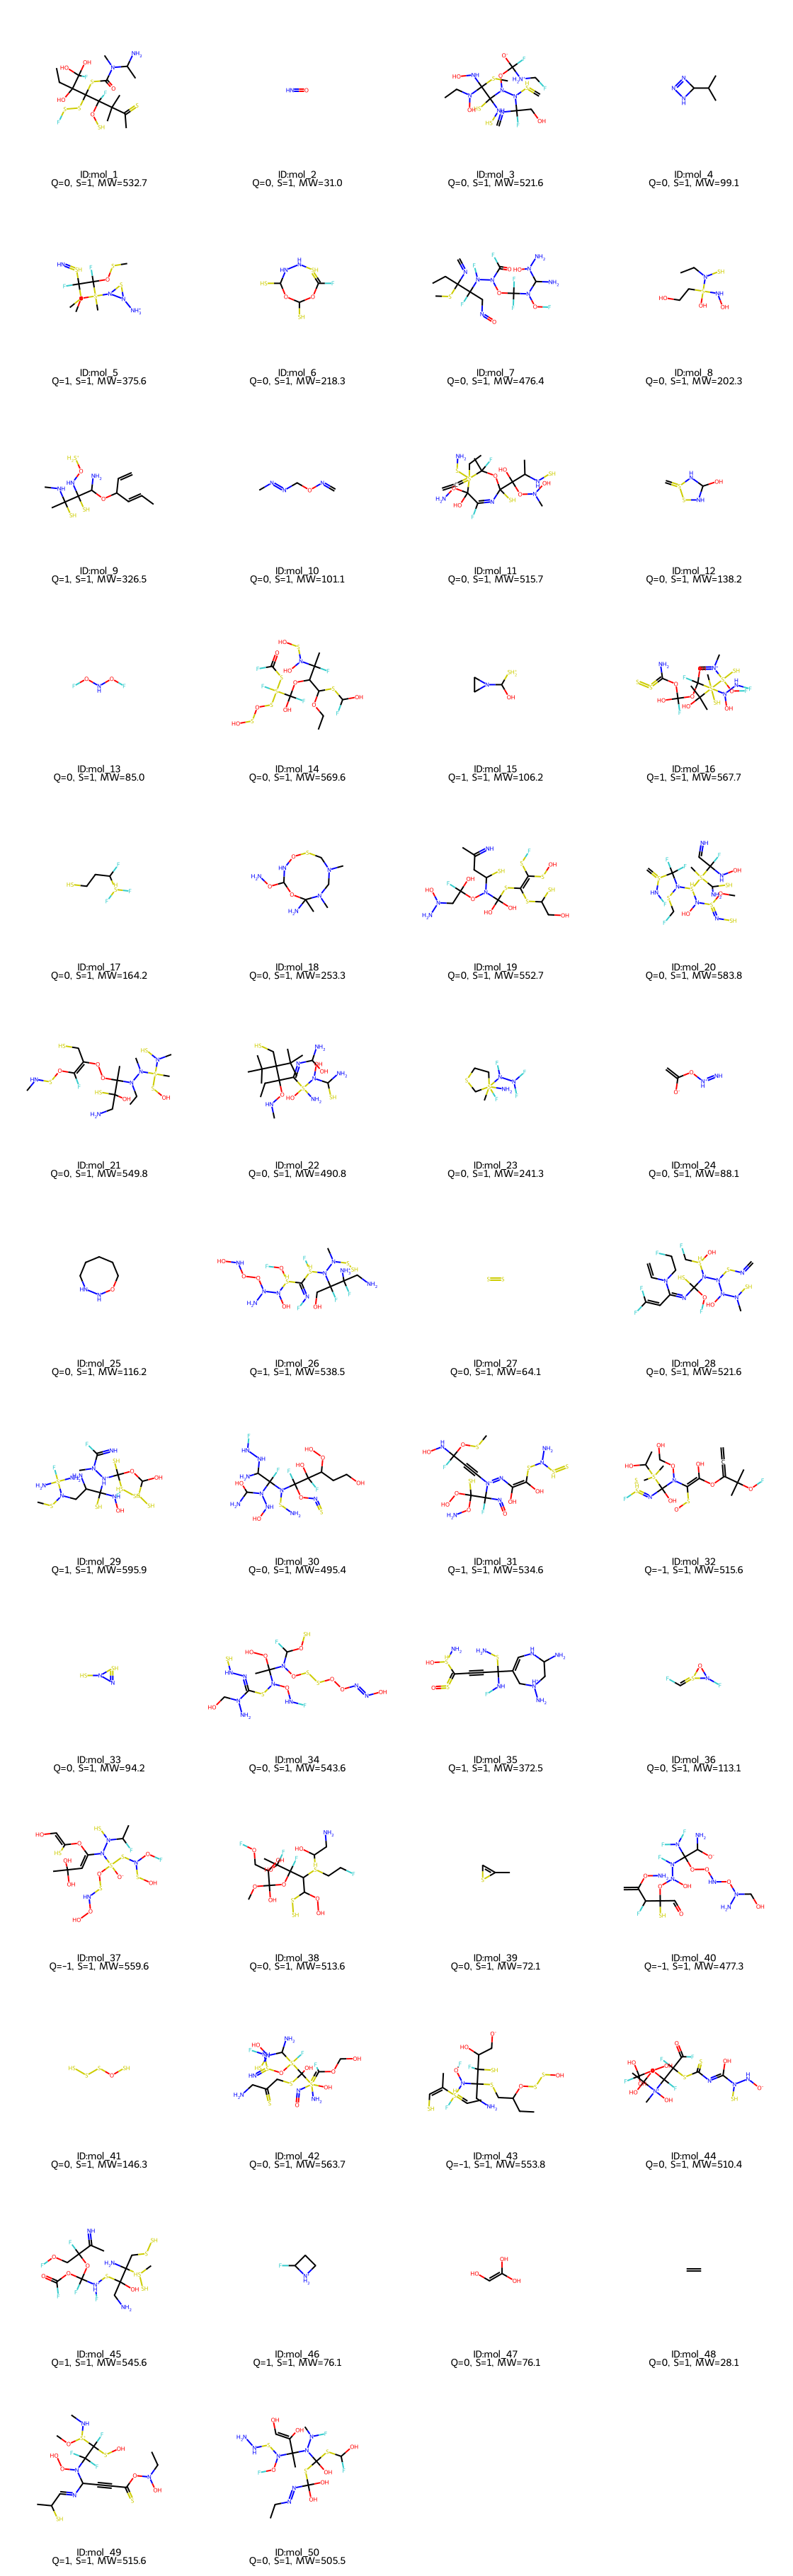

In [15]:
mols_to_grid_with_props(final_set)

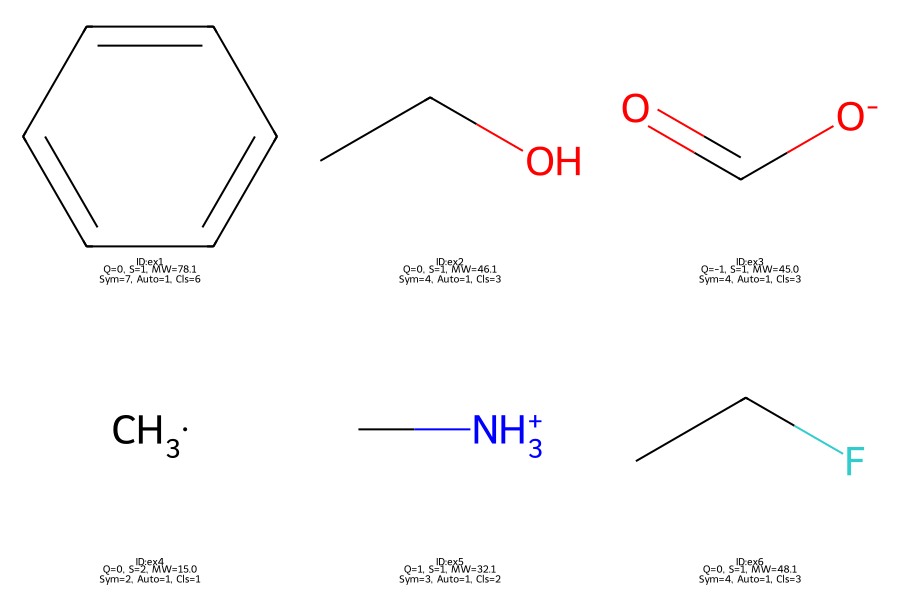

In [16]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, AllChem, rdmolops
from rdkit import RDLogger
import random
from collections import Counter

RDLogger.DisableLog("rdApp.*")  # silence warnings

# Allowed elements (no sulfur)
ALLOWED = {"C": [4], "N": [3,4], "O": [2,1], "F": [1]}

def symmetry_score(mol):
    try:
        autos = rdmolops.GetAutomorphisms(mol)
    except Exception:
        autos = []
    n_auto = max(1, len(autos))
    try:
        ranks = list(rdmolops.CanonicalRankAtoms(mol))
    except Exception:
        ranks = list(range(mol.GetNumAtoms()))
    cnt = Counter(ranks)
    class_sizes = sorted(cnt.values(), reverse=True)
    s2 = sum(c*c for c in class_sizes)
    score = n_auto * (1 + s2)
    return score, n_auto, len(cnt), class_sizes

def mols_to_grid_with_props(mols, n_cols=4, cell_size=(300, 300), use_svg=False):
    legends, out_mols = [], []
    for i, m in enumerate(mols):
        if m is None: 
            continue
        m = Chem.Mol(m)

        # ID
        mid = m.GetProp("_Name") if m.HasProp("_Name") else f"mol_{i+1}"

        # charge
        q = Chem.GetFormalCharge(m)

        # spin = radicals + 1
        n_rad = sum(a.GetNumRadicalElectrons() for a in m.GetAtoms())
        S = n_rad + 1

        # MW
        mw = Descriptors.MolWt(m)

        # symmetry
        s, n_auto, n_classes, class_sizes = symmetry_score(m)

        legends.append(
            f"ID:{mid}\nQ={q}, S={S}, MW={mw:.1f}\nSym={s}, Auto={n_auto}, Cls={n_classes}"
        )
        out_mols.append(m)

    img = Draw.MolsToGridImage(
        out_mols,
        molsPerRow=n_cols,
        subImgSize=cell_size,
        legends=legends,
        useSVG=use_svg,
    )
    return img

# --- Example usage ---
# if __name__ == "__main__":
smis = ["c1ccccc1", "CCO", "[O-]C=O", "[CH3]", "C[NH3+]", "CCF"]
mols = [Chem.MolFromSmiles(s) for s in smis]
for i, m in enumerate(mols):
    m.SetProp("_Name", f"ex{i+1}")
img = mols_to_grid_with_props(mols, n_cols=3, use_svg=False)
img  # in a notebook, just `img`


In [39]:
import pandas as pd

data = [
    # Td
    {"Name": "Methane",             "PointGroup": "Td",    "SMILES": "C"},
    {"Name": "Ammonium",            "PointGroup": "Td",    "SMILES": "[NH4+]"},
    {"Name": "Carbon tetrafluoride","PointGroup": "Td",    "SMILES": "FC(F)(F)F"},

    # D∞h
    {"Name": "Nitrogen",            "PointGroup": "Dinfh", "SMILES": "N#N"},
    {"Name": "Oxygen",              "PointGroup": "Dinfh", "SMILES": "O=O"},
    {"Name": "Carbon dioxide",      "PointGroup": "Dinfh", "SMILES": "O=C=O"},

    # C∞v
    {"Name": "Hydrogen fluoride",   "PointGroup": "Cinfv", "SMILES": "F"},
    {"Name": "Carbon monoxide",     "PointGroup": "Cinfv", "SMILES": "C#O"},
    {"Name": "Cyanide",             "PointGroup": "Cinfv", "SMILES": "[C-]#N"},

    # D3h
    {"Name": "Cyclopropenyl cation","PointGroup": "D3h",   "SMILES": "[c+]1cc1"},
    {"Name": "Nitrate",             "PointGroup": "D3h",   "SMILES": "[O-]N(=O)=O"},

    # C3v
    {"Name": "Ammonia",             "PointGroup": "C3v",   "SMILES": "N"},
    {"Name": "Nitrosyl cation",     "PointGroup": "C3v",   "SMILES": "[N+]#O"},
    {"Name": "Nitrogen trifluoride","PointGroup": "C3v",   "SMILES": "N(F)(F)F"},
    {"Name": "Trifluoromethane",    "PointGroup": "C3v",   "SMILES": "FC(F)F"},

    # C2v
    {"Name": "Water",               "PointGroup": "C2v",   "SMILES": "O"},
    {"Name": "Nitrite",             "PointGroup": "C2v",   "SMILES": "[O-]N=O"},
    {"Name": "Hydronium",           "PointGroup": "C2v",   "SMILES": "[OH3+]"},
    {"Name": "Hydrogen peroxide",   "PointGroup": "C2v",   "SMILES": "OO"},

    # Cs
    {"Name": "Formyl fluoride",     "PointGroup": "Cs",    "SMILES": "O=CF"},
    {"Name": "Fluoromethane",       "PointGroup": "Cs",    "SMILES": "CF"},
    {"Name": "Difluoromethane",     "PointGroup": "Cs",    "SMILES": "FCF"},
    {"Name": "Formate",             "PointGroup": "Cs",    "SMILES": "[O-]C=O"},
    {"Name": "Acetate",             "PointGroup": "Cs",    "SMILES": "CC(=O)[O-]"},

    # D2h / D6h
    {"Name": "Ethene",              "PointGroup": "D2h",   "SMILES": "C=C"},
    {"Name": "Benzene",             "PointGroup": "D6h",   "SMILES": "c1ccccc1"},

    # Td cation
    {"Name": "Tetrafluoroammonium", "PointGroup": "Td",    "SMILES": "[N+](F)(F)(F)F"},

    # Anions
    {"Name": "Fluoride",            "PointGroup": "Cinfv", "SMILES": "[F-]"},
    {"Name": "Hydroxide",           "PointGroup": "C2v",   "SMILES": "[OH-]"},

    # --- Chiral examples ---
    {"Name": "Fluorochlorobromomethane (proxy)", "PointGroup": "C1", "SMILES": "C(F)(Cl)Br"},  # NB: contains Cl/Br, see note
    {"Name": "CHFClBr analogue (replace with NF2CHCl for CHONF only)", "PointGroup": "C1", "SMILES": "C(F)(N)O"},  # using CHONF constraint
    {"Name": "Lactic acid (neutral)",            "PointGroup": "C1", "SMILES": "CC(O)C(=O)O"},
    {"Name": "Fluoroethanol (chiral center at C)", "PointGroup": "C1", "SMILES": "C[C@H](F)O"},
    {"Name": "Chiral amine",                     "PointGroup": "C1", "SMILES": "C[C@H](N)O"}
]

for i in range(2):
    data.append({"Name": "C"*i+"CO",                     "PointGroup": "C1", "SMILES": "C"*i+"CO"})
for i in range(2):
    data.append({"Name": "C"*i+"CF",                     "PointGroup": "C1", "SMILES": "C"*i+"CF"})
df = pd.DataFrame(data)
df



,Name,PointGroup,SMILES
0,Methane,Td,C
1,Ammonium,Td,[NH4+]
2,Carbon tetrafluoride,Td,FC(F)(F)F
3,Nitrogen,Dinfh,N#N
4,Oxygen,Dinfh,O=O
5,Carbon dioxide,Dinfh,O=C=O
6,Hydrogen fluoride,Cinfv,F
7,Carbon monoxide,Cinfv,C#O
8,Cyanide,Cinfv,[C-]#N
9,Cyclopropenyl cation,D3h,[c+]1cc1


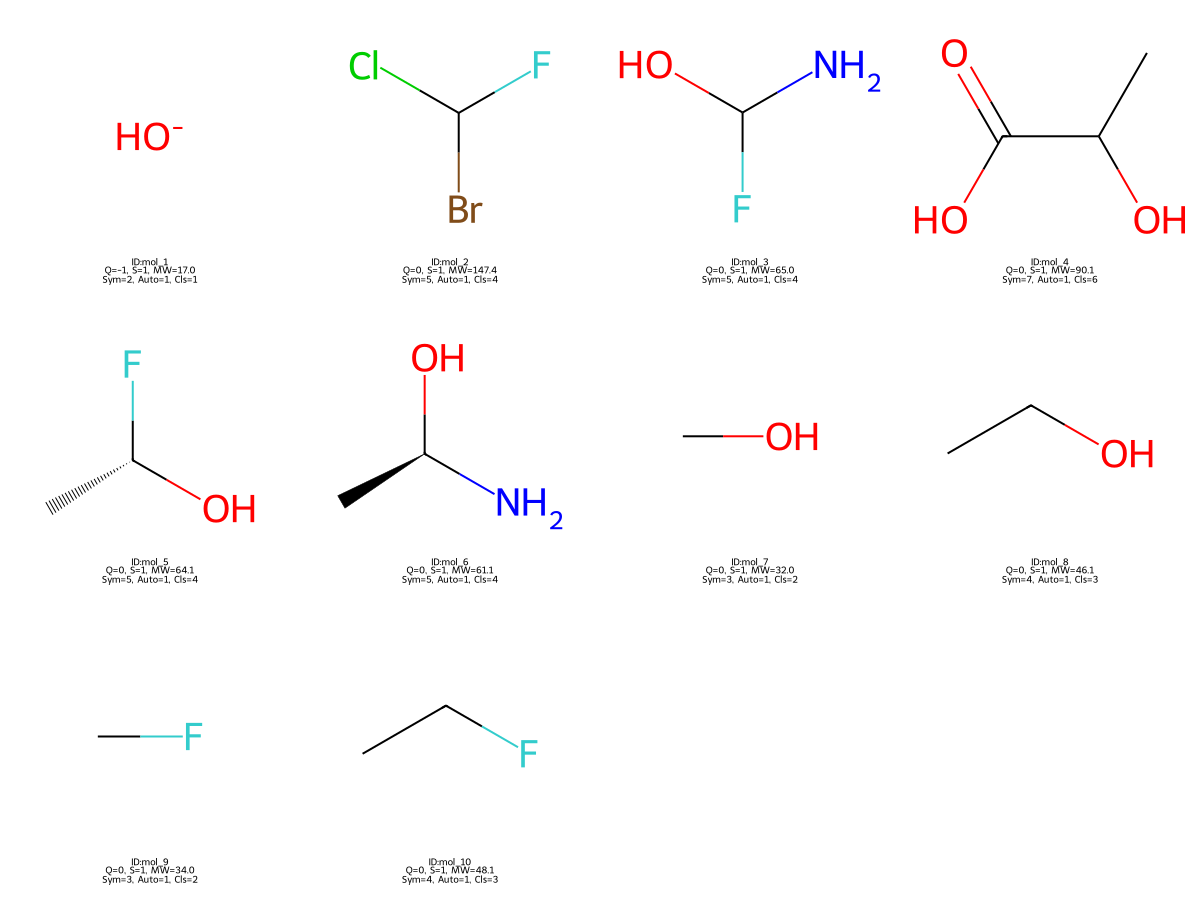

In [40]:
mols = [Chem.MolFromSmiles(s) for s in df.SMILES]
mols_to_grid_with_props(mols[-10:])

In [48]:
# SDF with properties
i = 0
for m in mols:
    w = rdmolfiles.SDWriter(f"benchmark_symmetry_{i}.sdf")
    if m is not None:
    # try to embed a quick 3D conformer so you can later check point-group-ish geometry if needed
        molH = Chem.AddHs(Chem.Mol(m))
        AllChem.EmbedMolecule(molH, AllChem.ETKDGv3())
        AllChem.UFFOptimizeMolecule(molH, maxIters=200)
        # m3d = Chem.RemoveHs(molH)
        for prop in m.GetPropNames():
            print(prop)
            m3d.SetProp(prop, m.GetProp(prop))
        w.write(molH)
    w.close()
    i+=1

In [49]:
import ase
from ase import io
from pathlib import Path

In [50]:
files = list(Path(".").glob("benchmark_symmetry*sdf"))

In [51]:
import ase
from ase import io
# dir(ase.io.read("benchmark_symmetry.sdf"))

import ase
from ase.io import read, write
for f in files:
    try:
        bec = ase.io.read(f)
        bec_new = ase.io.write(str(f)+".xyz", bec, format="xyz")
    except:
        pass